# Author: Shreya Dey

**What is the most accurate text mining classification tool to categorize three cancer types’ symptoms for the most accurate diagnosis?**

This is an important question because symptoms can be very similar sometimes especially for cancers like lung and thyroid that generally have similar symptoms. The smaller details that the machine algorithm picks up can allow for more accurate diagnosis. 

When classifying the results it was found that the best model for classifying and predicting the three types of cancer was the logtisc regression model with a 92% accuracy. Testing this model in a user input output interface provided the validation that rang this accuracy to be true. 

Data was taken from the kaggle database. This data contains three diffeternt cancer types -lung, colon, thyroid - and a variety of symptoms associated with each. 


## Installing and Importing Python Packages

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [5]:
#%% Import python modules and packages

# Tools to create a data frame(table)
import pandas as pd
from pandas import DataFrame

# Tools for text preprocessing
import nltk
import re

# Tools to remove stopwords
from nltk.corpus import stopwords

# Tools for tokenizing
from nltk.tokenize.toktok import ToktokTokenizer

# Tools for lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


#Package to help us expand contractions
import contractions

# Tools for plotting
import matplotlib.pyplot as plt

# Tools for doing word frequencies
from nltk.util import ngrams

# Tools for feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Machine learning model building: Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression Import Packages
from sklearn.linear_model import LogisticRegression

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading in the data

In [6]:
#%% Read in Cancer train csv file
data = pd.read_csv('/kaggle/input/cancercsv/cancer.csv', encoding='latin-1')

In [7]:
# Preview of the dataset 
data.head()

,Unnamed: 0,Cancer,Text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


## Text Preprocessing

In [8]:
#%% Defining a function to perform stemming
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    # split the text into individual word and return a list of words
    # the 'ps' function stems each word, and .join() function joins the stemmed words with whitespace.
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [9]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no') # we will not remove 'no' from texts
stopword_list.remove('not') # we will not reomve 'not' from texts
def remove_stopwords(text, is_lower_case=False):
    # First, tokenize the text
    tokens = tokenizer.tokenize(text)
    # remove whitespaces in each token
    tokens = [token.strip() for token in tokens]
    # if "is_lower_case" parameter is True,
    # we will not remove stopwords that have any upper case letter
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    # If "is_lower_case" parameter is False,
    # we will remove any stopwords no matter whether they are in uppercase or not
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [10]:
#%% Defining a function to perform lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    s = " " # create an empty string that later will contain lemmatized words,
    t_l = [] # create an empty list
    t_w = nltk.word_tokenize(text) # tokenize the text
    # assign the list of tokenized words into t_w.
    for w in t_w:
        # “pos” is a part of speech parameter and “v” means verbs.
        # We will lemmatize verbs only.
        l_w = wordnet_lemmatizer.lemmatize(w, pos="v")
        # append l_w into the list t_l
        t_l.append(l_w)
    # joint the tokens to make a complete sentence
    text = s.join(t_l)
    return text

In [11]:
#%% Defining a function to remove special characters
def remove_special_characters(text, remove_digits=False):
    '''
    A caret located in a bracket means ‘not.’
    If remove_digits parameter is True, "^a-zA-Z0-9\s" matches any characters other than
    alphabets ([a-zA-Z]) or digits ([0-9]), followed by a white space ([\s]).
    If 'remove_digits' parameter is False, the the function will remove numbers as well.
    '''
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [12]:
#%% This function takes all the previous preprocessing functions and combines them

def normalize_corpus(corpus, text_lower_case=True,
                     text_lemmatization=True, special_char_removal=True,
                     stopword_removal=True, remove_digits=True):

    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # lowercase the text
        if text_lower_case:
            doc = str(doc)
            doc = doc.lower()
        doc = contractions.fix(doc)  #Make contractions into full form
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        doc = re.sub('`', '', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)

        normalized_corpus.append(doc)

    return normalized_corpus

In [13]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [14]:
#%% Normalize the text data and add a new column on the csv file of the preprocessed text
data['cancer_text'] = normalize_corpus(data['Text'])

In [15]:
# Preview the data 
data.head()

,Unnamed: 0,Cancer,Text,cancer_text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,thyroid surgery children single institution os...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",adopt strategy use prior years [ ] base four e...
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,coronary arterybypass graft thrombosis brin br...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,solitary plasmacytoma sp skull uncommon clinic...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,study aim investigate serum matrix metalloprot...


## Exploratory Data Analysis

<Axes: >

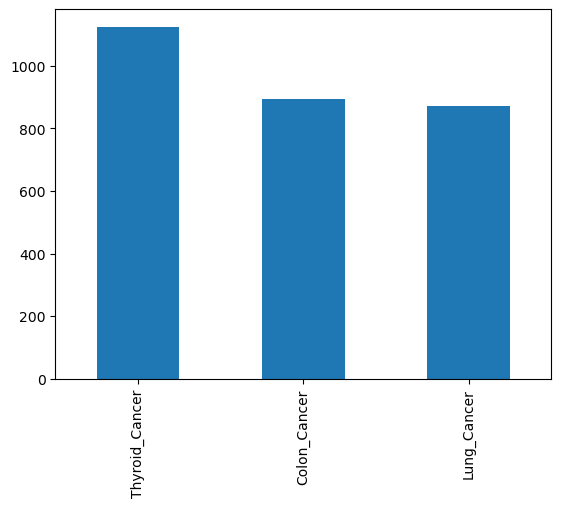

In [16]:
# Histogram
data['Cancer'].value_counts().plot(kind = 'bar')

In [17]:
data.isnull().sum()

Unnamed: 0     0
Cancer         0
Text           0
cancer_text    0
dtype: int64

## Word Cloud

In [18]:
# Convert the 'Column1' to string type
data['cancer_text'] = data['cancer_text'].astype(str)

In [19]:
from collections import Counter

In [20]:
# Count the frequency of each token using the Counter class from the collections module,
# and retrieve the 'num' most common tokens

# Make a definition to extract keywords
# Split the text into separate words (tokens)

#Count the number of tokens that occured most frequency
# Store them in a python dictionary
def extract_keywords(text, num = 50):
  tokens = []
  for tok in text.split():
      tokens.append(tok)
  most_common_tokens = Counter(tokens).most_common(num)
  return dict(most_common_tokens)

In [21]:
# list of cancers
cancer_list = data['Cancer'].unique().tolist()

Thyroid Cancer WordCloud

In [22]:
thyroid_list = data[data['Cancer'] == 'Thyroid_Cancer']['cancer_text'].tolist()

In [23]:
# Thyroid Cancer Document
thyroid_docx = ' '.join(thyroid_list)

In [24]:
# Extract Keywords
keyword_thyroid = extract_keywords(thyroid_docx)

In [25]:
keyword_thyroid

{']': 34852,
 '[': 34844,
 'cancer': 23540,
 'patients': 22924,
 'use': 19792,
 'study': 18732,
 'cells': 18544,
 'expression': 13364,
 'cell': 13220,
 'p': 12116,
 'not': 10200,
 'data': 10048,
 'show': 9872,
 'fig': 9544,
 'level': 9508,
 'c': 9100,
 'group': 9000,
 'j': 8160,
 'include': 8080,
 'also': 7920,
 'disease': 7820,
 'result': 7720,
 'analysis': 7600,
 'tumor': 7544,
 'report': 7528,
 'treatment': 7316,
 'increase': 7244,
 'no': 7132,
 'b': 7064,
 'genes': 6984,
 'et': 6716,
 'n': 6712,
 'find': 6564,
 'clinical': 6456,
 'tissue': 6156,
 'case': 6132,
 'sample': 5940,
 'factor': 5924,
 'protein': 5868,
 'breast': 5848,
 'may': 5840,
 'compare': 5784,
 'h': 5644,
 'e': 5636,
 'risk': 5608,
 'gene': 5512,
 'effect': 5468,
 'control': 5352,
 'one': 5344,
 'associate': 5148}

In [26]:
# Define function used for Word Cloud
def plot_wordcloud(docx):
  mywordcloud = WordCloud().generate(docx)
  plt.figure(figsize =(20,10))
  plt.imshow(mywordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.show()

In [27]:
from wordcloud import WordCloud

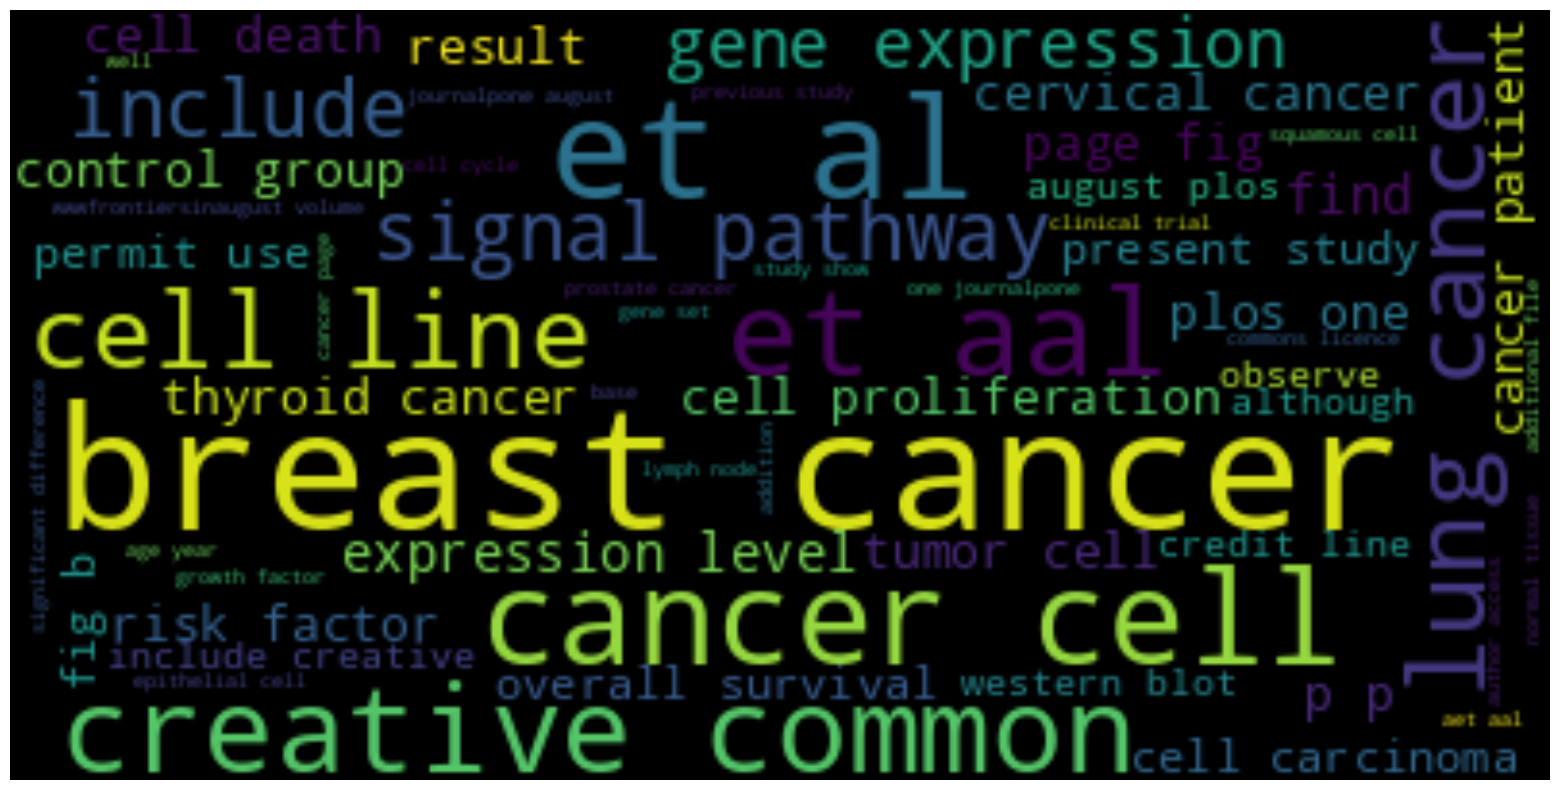

In [28]:
plot_wordcloud(thyroid_docx)

Lung Cancer Word Cloud

In [29]:
lung_list = data[data['Cancer'] == 'Lung_Cancer']['cancer_text'].tolist()

In [30]:
# Lung Cancer Document
lung_docx = ' '.join(lung_list)

In [31]:
# Extract Keywords
keyword_lung = extract_keywords(lung_docx)

In [32]:
keyword_lung

{'cancer': 14042,
 'lung': 11044,
 '[': 9262,
 ']': 9260,
 'cells': 9028,
 'patients': 8746,
 'use': 7540,
 'study': 7446,
 'cell': 6162,
 'p': 5980,
 'tumor': 5372,
 'expression': 5192,
 'result': 4212,
 'c': 4030,
 'not': 3996,
 'show': 3932,
 'j': 3826,
 'data': 3758,
 'analysis': 3738,
 'h': 3716,
 'test': 3600,
 'treatment': 3598,
 'nsclc': 3526,
 'b': 3431,
 'group': 3056,
 'model': 2830,
 'al': 2736,
 'et': 2728,
 'level': 2726,
 'sample': 2640,
 'control': 2624,
 'egfr': 2606,
 'survival': 2594,
 'compare': 2552,
 'case': 2490,
 'increase': 2450,
 'gene': 2416,
 'n': 2340,
 'e': 2338,
 'no': 2294,
 'also': 2206,
 'find': 2152,
 'include': 2136,
 'clinical': 2044,
 'risk': 2042,
 'effect': 2040,
 'protein': 2034,
 'perform': 2012,
 'g': 1994,
 'figure': 1984}

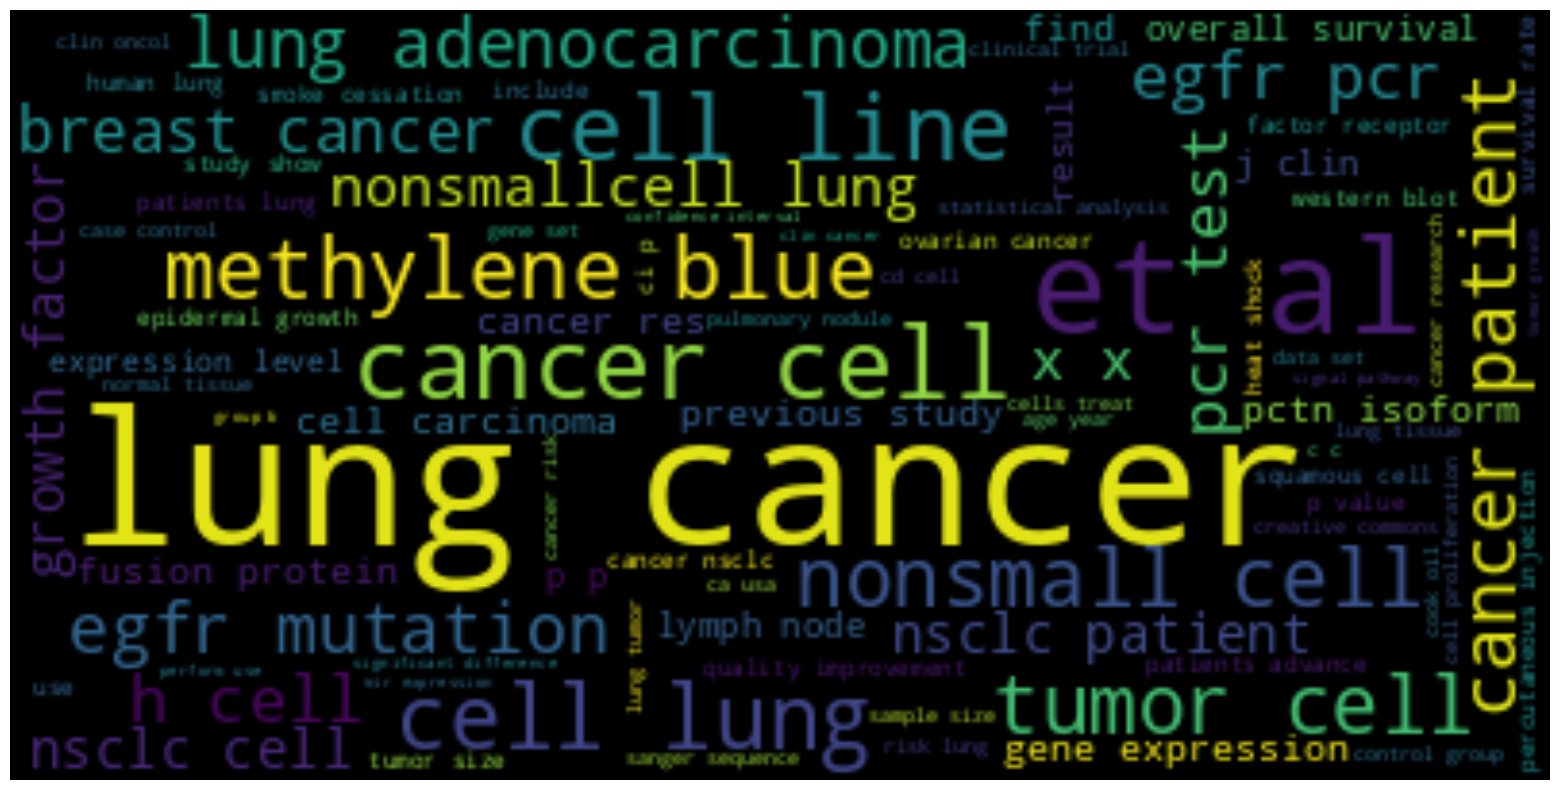

In [33]:
plot_wordcloud(lung_docx)

Colon Cancer WordCloud

In [34]:
colon_list = data[data['Cancer'] == 'Colon_Cancer']['cancer_text'].tolist()

In [35]:
# Colon Cancer Document
colon_docx = ' '.join(colon_list)

In [36]:
# Extract Keywords
keyword_colon = extract_keywords(colon_docx)

In [37]:
keyword_colon

{'cancer': 19559,
 'cells': 19411,
 'use': 16771,
 'patients': 15072,
 'study': 14824,
 'cell': 13707,
 'expression': 12212,
 'p': 10750,
 'show': 9094,
 'fig': 9087,
 '[': 8883,
 ']': 8385,
 'c': 8189,
 'data': 8014,
 'not': 7923,
 'group': 7505,
 'tumor': 7417,
 'level': 6746,
 'analysis': 6718,
 'also': 6586,
 'b': 6580,
 'result': 6363,
 'increase': 6074,
 'j': 6017,
 'genes': 5985,
 'treatment': 5945,
 'include': 5881,
 'tissue': 5548,
 'effect': 5482,
 'protein': 5391,
 'find': 5381,
 'h': 5337,
 'no': 5024,
 'report': 4869,
 'gene': 4814,
 'compare': 4430,
 'e': 4408,
 'n': 4336,
 'disease': 4276,
 'control': 4217,
 'clinical': 4157,
 'factor': 4153,
 'mice': 4136,
 'indicate': 4103,
 'figure': 4103,
 'survival': 4053,
 'page': 3981,
 'sample': 3972,
 'may': 3968,
 'activity': 3944}

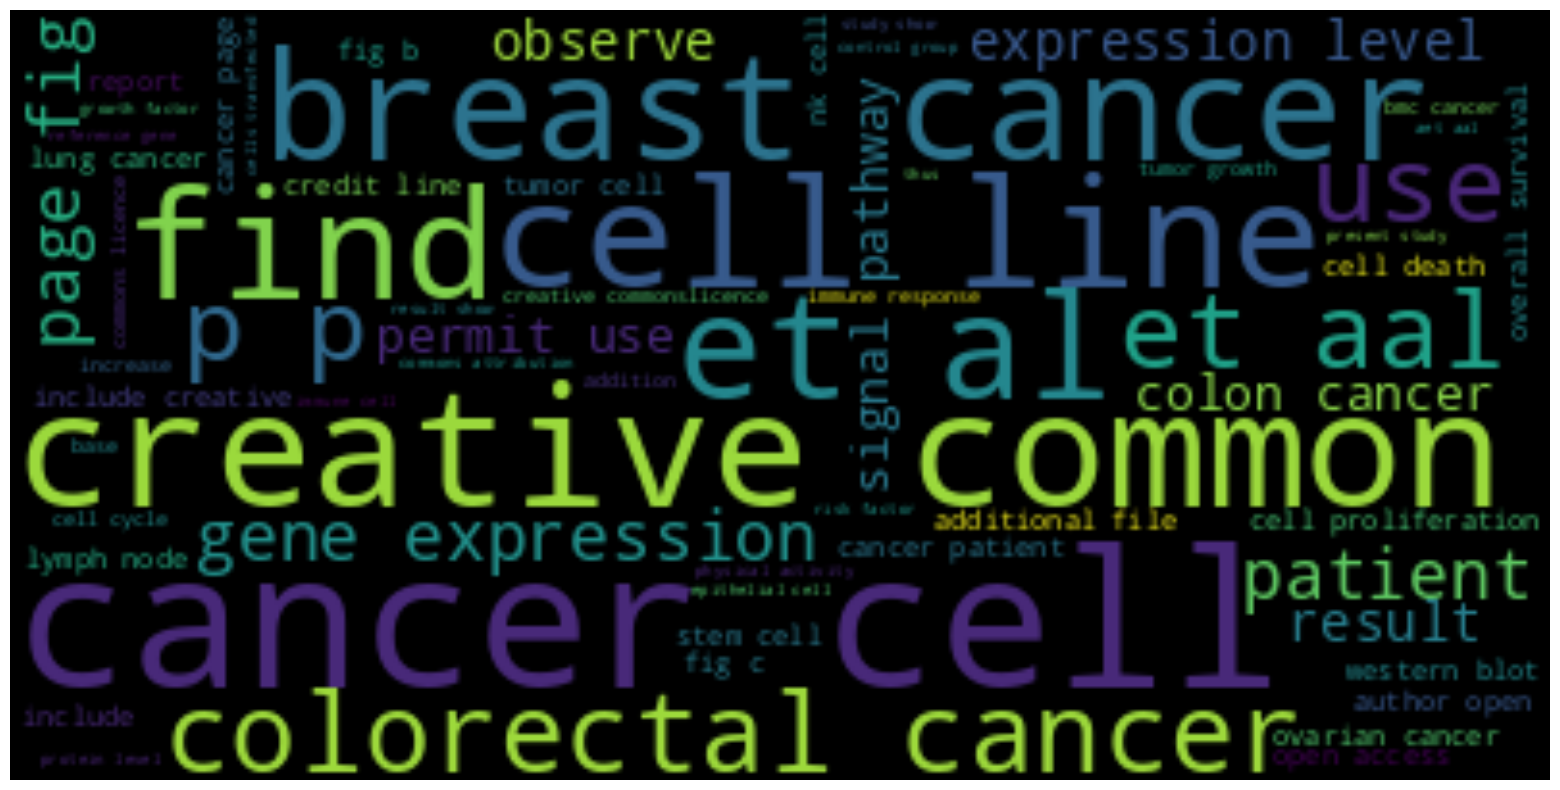

In [38]:
plot_wordcloud(colon_docx)

## Extracting Features

In [39]:
# Taking a Glance at the Data
data.head()

,Unnamed: 0,Cancer,Text,cancer_text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,thyroid surgery children single institution os...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",adopt strategy use prior years [ ] base four e...
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,coronary arterybypass graft thrombosis brin br...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,solitary plasmacytoma sp skull uncommon clinic...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,study aim investigate serum matrix metalloprot...


In [40]:
# Labeling features and cancer type
XFeatures = data['cancer_text']
ylabels = data['Cancer']

In [41]:
#tfidf_vectorizer = TfidfVectorizer(max_features= 173573)  # You can adjust the number of features as needed

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(XFeatures)

# Get features by name
feature_names = tfidf_vectorizer.get_feature_names_out()

# Open a text file in write mode
file_path = "feature_names.txt"  # Replace with your desired file path and name
with open(file_path, 'w') as file:
    # Write the feature names to the file
    for feature in feature_names:
        file.write(feature + '\n')

In [42]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Machine Learning Classification Model

In [43]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X,ylabels, test_size = 0.3, random_state = 42)

In [44]:
# Create a definition for predicting cancer type

def predict_cancer(sample_text,model):
  vector = tfidf_vectorizer.transform(sample_text).toarray() # Transforming our text data into vectors (numbers)
  prediction = model.predict(vector)          # Putting our data into the model
  pred_proba = model.predict_proba(vector)     # Confidence of our prediction
  pred_percent = dict(zip(model.classes_, pred_proba[0]))
  print(prediction)
  return pred_percent

In [45]:
# Using the logistic regression model & insert the data
lr_model = LogisticRegression(multi_class = 'multinomial')
lr_model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [46]:
# Accuracy
lr_model.score(X_test, y_test)

0.9182027649769585

In [47]:
# Testing the model

sample = ["blood in the stool, abdominal discomfort, and a change in bowel habits, such as diarrhea or constipation"
]

In [48]:
predict_cancer(sample, lr_model)

['Colon_Cancer']


{'Colon_Cancer': 0.441690290115235,
 'Lung_Cancer': 0.17090238372751168,
 'Thyroid_Cancer': 0.3874073261572532}

In [49]:
# Build model: Naive Bayes

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Test the accuracy
nb_model.score(X_test, y_test)

# Predictions
y_predict = nb_model.predict(X_test)


cv = CountVectorizer()
X = cv.fit_transform(XFeatures)

sample_text = data

vector = cv.transform(sample_text).toarray()

# Get feature names
cv.get_feature_names_out()

nb_model.classes_

array(['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer'], dtype='<U14')

## Keyword Extraction using NER

In [50]:
# NER = Named Entity Recognition for Medical Terms
import spacy
from spacy.lang.en import English

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Initialize the English tokenizer
tokenizer = English()

def preprocess(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = tokenizer(text)

    # Remove punctuation and stopwords
    keywords = [token.text for token in tokens if not token.is_punct and not token.is_stop]

    return keywords

def extract_medical_keywords(text):
    # Preprocess the text
    keywords = preprocess(text)

    # NER to identify medical entities
    doc = nlp(text)
    medical_keywords = [ent.text for ent in doc.ents if ent.label_ in ["CONDITION", "TREATMENT", "MEDICATION"]]

    # Combine keywords and medical entities
    keywords.extend(medical_keywords)

    return keywords



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [51]:
# Applying the Extract Medical Keywords function to cancer symptoms
data['medical_keywords'] = data['Text'].apply(extract_medical_keywords)

In [52]:
separator = ", "

# Using join() with a list comprehension to convert the list to a string without square brackets
data['medical_keywords'] = separator.join([item for sublist in data["medical_keywords"] for item in sublist])

In [53]:
# Labeling
XFeatures = data['medical_keywords']
ylabels = data['Cancer']

In [54]:
data.head()

,Unnamed: 0,Cancer,Text,cancer_text,medical_keywords
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,thyroid surgery children single institution os...,"thyroid, surgery, , children, single, institu..."
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",adopt strategy use prior years [ ] base four e...,"thyroid, surgery, , children, single, institu..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,coronary arterybypass graft thrombosis brin br...,"thyroid, surgery, , children, single, institu..."
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,solitary plasmacytoma sp skull uncommon clinic...,"thyroid, surgery, , children, single, institu..."
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,study aim investigate serum matrix metalloprot...,"thyroid, surgery, , children, single, institu..."
